<a href="https://colab.research.google.com/github/sayanarajasekhar/PyTorch/blob/main/Multi_class_classification_problem_make_gaussian_quantiles.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Multi-class classification problem make_gaussian_quantiles

## 1. Import Libraries

In [240]:
import torch
from torch import nn
import matplotlib.pyplot as plt

## 2. Creating device agonistic code

In [241]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

## 3. Make a multi-class classification dataset with Scikit-Learn's `make_gaussian_quantiles()` function.

In [242]:
from sklearn.datasets import make_gaussian_quantiles
from sklearn.model_selection import train_test_split

N_SAMPLES = 1000
N_FEATURES = 5
N_CLASSES = 3

X, y = make_gaussian_quantiles(
    n_samples = N_SAMPLES,
    n_features = N_FEATURES,
    n_classes = N_CLASSES,
    shuffle = True,
    random_state = 42
)

len(X), len(y)

(1000, 1000)

In [243]:
X.shape, y.shape

((1000, 5), (1000,))

## 4. Visualize data

In [244]:
import pandas as pd
circles = pd.DataFrame({"X1": X[:, 0],
                        "X2": X[:, 1],
                        "labels": y})
circles.head(10)

,X1,X2,labels
0,-1.119546,-0.393530,1
1,1.080781,0.833922,1
2,0.361504,-1.143726,0
3,0.280161,-0.809604,0
4,-1.669405,0.543360,1
5,-1.002529,-0.018513,0
6,1.431367,1.081767,2
7,-0.219672,0.357113,1
8,-0.015310,0.579291,0
9,-0.767348,0.872321,2


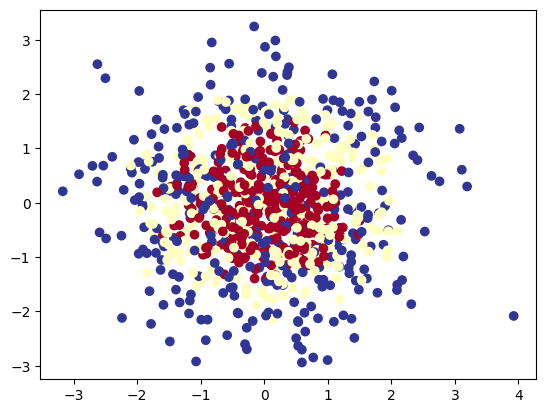

In [245]:
# Visualization data in plt
import matplotlib.pyplot as plt

plt.scatter(x = X[:, 0],
            y = X[:, 1],
            c = y,
            cmap = plt.cm.RdYlBu)

## 5. Split train and test data

In [246]:
X = torch.from_numpy(X).type(torch.float).to(device)
y = torch.from_numpy(y).type(torch.LongTensor).to(device)

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size = 0.2,
    shuffle = True,
    random_state = 42
)

len(X_train), len(X_test), len(y_train), len(y_test)

(800, 200, 800, 200)

## 6. Building a model with non-linearity

In [247]:
class GaussianQuantiles(nn.Module):
  def __init__(self, features, classes):
    super().__init__()
    self.layers = nn.Sequential(
      nn.Linear(in_features = features, out_features = 8),
      nn.ReLU(),
      nn.Linear(in_features = 8, out_features = 8),
      nn.ReLU(),
      nn.Linear(in_features = 8, out_features = classes)
    )

  def forward(self, x:torch.Tensor) -> torch.Tensor:
    return self.layers(x).squeeze()

In [248]:
torch.manual_seed(42)
model_0 = GaussianQuantiles(N_FEATURES, N_CLASSES)
model_0

GaussianQuantiles(
  (layers): Sequential(
    (0): Linear(in_features=5, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=3, bias=True)
  )
)

## 7. Create Loss function and Optimizer

In [255]:
# Loss function
loss_fn = nn.CrossEntropyLoss()

# Optimizer
optimizer = torch.optim.SGD(params = model_0.parameters(),
                            weight_decay = 0.0001,
                            lr = 0.03)

## 8. Training and Testing loop

In [250]:
def accuracy(y_true, y_pred):
  correct = torch.eq(y_true, y_pred).sum().item()
  acc = (correct/len(y_pred)) * 100
  return acc

In [256]:
epochs = 5000

for epoch in range(epochs):

  ### Train
  model_0.train()

  # 1. Forward pass
  train_logits = model_0(X_train)
  train_preds = torch.softmax(train_logits, dim = 1).argmax(dim = 1)

  # 2. Calculate loss / accuracy
  train_loss = loss_fn(train_logits, y_train)
  train_acc = accuracy(y_true = y_train, y_pred = train_preds)

  # 3. Optimize zero grad
  optimizer.zero_grad()

  # 4. Loss backward
  train_loss.backward()

  # 5. Optimize step
  optimizer.step()

  ### Test
  model_0.eval()
  with torch.inference_mode():
    # 1. Forward pass
    test_logits = model_0(X_test)
    test_preds = torch.softmax(test_logits, dim = 1).argmax(dim = 1)

    # 2. Calculate loss / accuracy
    test_loss = loss_fn(test_logits, y_test)
    test_acc = accuracy(y_true = y_test, y_pred = test_preds)

  if epoch % 500 == 0:
    print(f"Epoch: {epoch} | Train Loss: {train_loss:.5f} Acc: {train_acc:.2f}% | Test Loss: {test_loss:.5f} Acc: {test_acc:.2f}%")


Epoch: 0 | Train Loss: 0.19554 Acc: 93.75% | Test Loss: 0.24495 Acc: 88.50%
Epoch: 500 | Train Loss: 0.18972 Acc: 93.62% | Test Loss: 0.24441 Acc: 88.00%
Epoch: 1000 | Train Loss: 0.18443 Acc: 93.50% | Test Loss: 0.24527 Acc: 88.50%
Epoch: 1500 | Train Loss: 0.18036 Acc: 93.12% | Test Loss: 0.24714 Acc: 90.00%
Epoch: 2000 | Train Loss: 0.17721 Acc: 93.25% | Test Loss: 0.24810 Acc: 90.00%
Epoch: 2500 | Train Loss: 0.17450 Acc: 93.00% | Test Loss: 0.24763 Acc: 90.00%
Epoch: 3000 | Train Loss: 0.17214 Acc: 93.00% | Test Loss: 0.24673 Acc: 90.00%
Epoch: 3500 | Train Loss: 0.17000 Acc: 93.25% | Test Loss: 0.24672 Acc: 90.00%
Epoch: 4000 | Train Loss: 0.16808 Acc: 93.38% | Test Loss: 0.24662 Acc: 90.00%
Epoch: 4500 | Train Loss: 0.16629 Acc: 93.38% | Test Loss: 0.24617 Acc: 90.00%
